In [24]:
import torch
from torch import nn, optim, tensor, Tensor
from torchdiffeq import odeint, odeint_adjoint
from torchdyn.datasets import ToyDataset
import matplotlib.pyplot as plt
from matplotlib import animation
import progressbar
import pandas as pd
import os

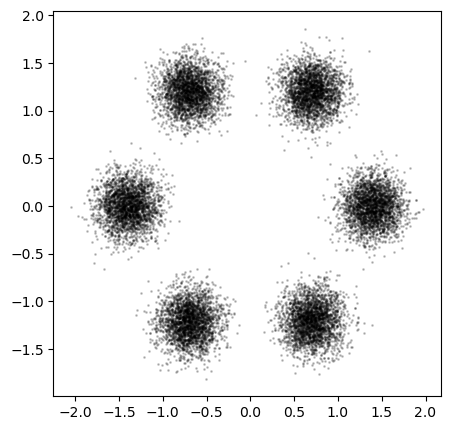

In [2]:
n_samples = 2 ** 14 # the number of samples
n_gaussians = 6 # the number of Gaussians

X, _ = ToyDataset().generate(n_samples // n_gaussians,
                              'gaussians',
                              n_gaussians=n_gaussians,
                              std_gaussians=.5,
                              radius=4,dim=2)


X = (X - X.mean()) / X.std()

plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c='black', alpha=0.2, s=1.)


In [3]:
def autograd_trace(x_out, x_in):
    """
    `autograd_trace`:(`x_out`, `x_in`): compute the trace of the Jacobian of `x_out` w.r.t. `x_in` using autograd.
    """
    trJ = 0.
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(x_out[:,i].sum(), x_in, create_graph=True)[0].contiguous()[:,i].contiguous()
    return trJ.contiguous()

class CNF(nn.Module):
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.planar = Planar(in_out_dim, hidden_dim, width)

    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            w,u,b = self.planar(t)

            Z = torch.unsqueeze(z,0).repeat(self.width, 1,1)

            h = torch.tanh(torch.matmul(Z,w) + b)
            dz_dt = torch.matmul(h, u).mean(0)

            dlogp_z_dt = -autograd_trace(dz_dt, z).view(batchsize, 1)

        return (dz_dt, dlogp_z_dt)

class Planar(nn.Module):
    """
    Construct a net according to the Planar Flow: return the params of the flow:
    u, w, b
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()

        blocksize = width * in_out_dim

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        params = t.reshape(1,1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)
        params = params.reshape(-1)

        w = params[:self.blocksize].reshape(self.width, self.in_out_dim, 1)
        u = params[self.blocksize:2*self.blocksize].reshape(self.width, 1,self.in_out_dim)
        g = params[2*self.blocksize:3*self.blocksize].reshape(self.width, 1,self.in_out_dim)
        u = u*torch.sigmoid(g)

        b = params[3 * self.blocksize:].reshape(self.width,1,1)
        return [w,u,b]

In [4]:
'cus' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

'mps'

In [18]:
t0 = 0
t1 = 10
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

func = CNF(in_out_dim=2, hidden_dim=64, width=3).to(device)
optimizer = optim.Adam(func.parameters(), lr=5e-3)
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[1, 0.0], [0.0, 1]]).to(device)
)


df = pd.DataFrame(columns=["itr", "loss"])

In [19]:
checkpoint = torch.load('six-gaussians700.pt', map_location=device)
checkpoint["loss"]
func.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
func.eval()

CNF(
  (planar): Planar(
    (fc1): Linear(in_features=1, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=21, bias=True)
  )
)

In [20]:
z0_vis = p_z0.sample([10000])
logp_z0_vis = torch.zeros(10000).to(device)
t = torch.linspace(t0,t1,500)

z1_vis = odeint(func,
                (z0_vis,logp_z0_vis),
                # torch.Tensor([t0,t1]),
                t, 
                atol = 1e-5,
                rtol = 1e-5,
                method ='dopri5'
                )[0]



In [21]:
def animate(i):
    ax.cla()
    if i < 30:
        ax.scatter(*X.T, s=1.)
        ax.scatter(*z1_vis[0].detach().cpu().T, s=1., alpha=0.8)
    elif 30 <= i < 530:
        ax.scatter(*X.T, s=1.)
        ax.scatter(*z1_vis[i-30].detach().cpu().T, s=1., alpha=0.8)
    else:
        ax.scatter(*X.T, s=1.)
        ax.scatter(*z1_vis[-1].detach().cpu().T, s=1., alpha=0.8)
        
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)

In [23]:
ani = animation.FuncAnimation(fig, animate, frames=560)
writer = animation.PillowWriter(fps=30,
                                # metadata=dict(artist='Me'),
                               )
ani.save('six-gaussians.gif', writer = writer) 


(-4.0, 4.0)

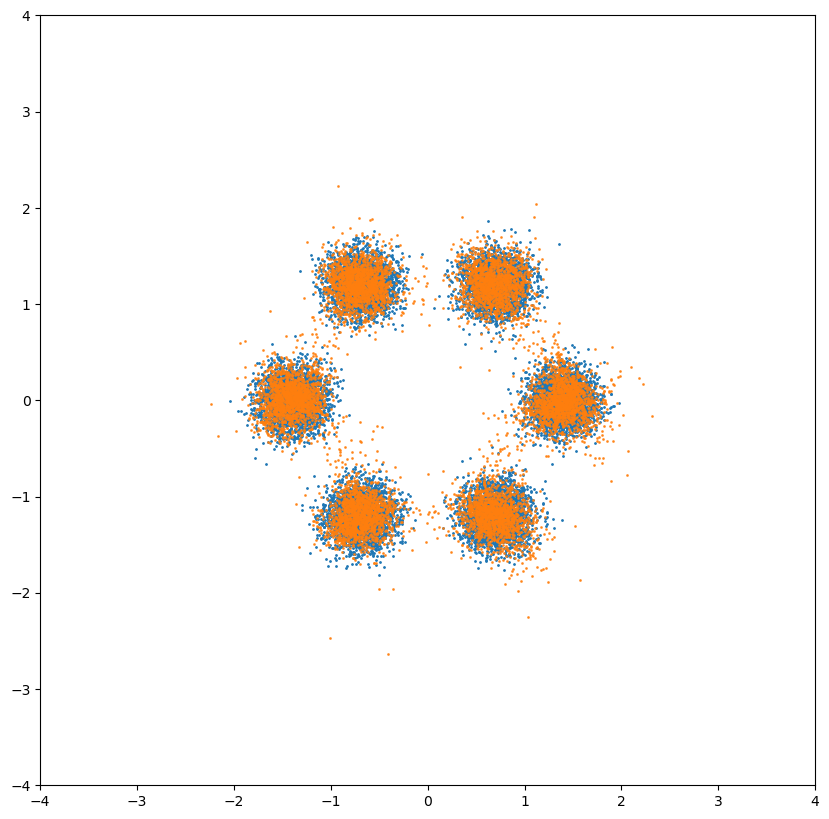

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(*X.T, s=1.)
ax.scatter(*z1_vis[-1].detach().cpu().T, s=1., alpha=0.8)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)

In [140]:
r = r"\d+"

In [145]:
r

'\\d+'

In [144]:
[i for i in os.listdir() if ".pt" in i]

['moons1700.pt',
 'moons4000.pt',
 'moons5600.pt',
 'moons8300.pt',
 'moons7600.pt',
 'moons2100.pt',
 'moons200.pt',
 'moons3700.pt',
 'moons6000.pt',
 'moons6100.pt',
 'moons300.pt',
 'moons3600.pt',
 'moons2000.pt',
 'moons7700.pt',
 'moons8200.pt',
 'moons5700.pt',
 'moons4100.pt',
 'moons1600.pt',
 'moons7000.pt',
 'moons2700.pt',
 'moons400.pt',
 'moons3100.pt',
 'moons6600.pt',
 'moons1100.pt',
 'moons4600.pt',
 'moons5000.pt',
 'moons800.pt',
 'moons8500.pt',
 'moons8400.pt',
 'moons900.pt',
 'moons5100.pt',
 'moons4700.pt',
 'moons1000.pt',
 'moons8800.pt',
 'moons6700.pt',
 'moons500.pt',
 'moons3000.pt',
 'moons2600.pt',
 'moons7100.pt',
 'moons6400.pt',
 'moons3300.pt',
 'moons600.pt',
 'moons2500.pt',
 'moons7200.pt',
 'moons4800.pt',
 'moons6800.pt',
 'moons8700.pt',
 'moons2900.pt',
 'moons5200.pt',
 'moons4400.pt',
 'moons1300.pt',
 'moons1200.pt',
 'moons4500.pt',
 'moons5300.pt',
 'moons2800.pt',
 'moons6900.pt',
 'moons8600.pt',
 'moons4900.pt',
 'moons7300.pt',
 'mo

In [214]:
n_gaussians = 6
def get_batch(num_samples):
    points, _ = ToyDataset().generate(n_samples=num_samples, noise=2e-1, dataset_type='moons')

    X = ((points - points.mean()) / points.std()).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(X.size(0), 1).type(torch.float32).to(device)

    return (X,logp_diff_t1)



In [216]:
for itr in progressbar.progressbar(range(checkpoint['epoch']+1, checkpoint['epoch'] + 2000 + 1)):
    optimizer.zero_grad()

    x, logp_diff_t1 = get_batch(5000)
    z_t, logp_diff_t = odeint(
                func,
                (x, logp_diff_t1),
                torch.tensor([t1, t0]).type(torch.float32).to(device),
                atol=1e-5,
                rtol=1e-5,
                method='dopri5',
            )
    z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

    # logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
    # loss = -logp_x.mean(0)
    C = 1/2 * z_t0.norm(dim=1,p=2) ** 2 + logp_diff_t0.view(-1) + torch.log(Tensor([2 * torch.pi]).to(device))
    loss = C.mean(0)


    loss.backward()
    optimizer.step()
    df.loc[len(df.index)] = [itr, loss.item()]

    # if itr % 100 == 0:
      # save_checkpoint(func, itr, optimizer, loss.item(), PATH=os.path.join(p2drive,"moons","moons{}.pt".format(itr)))
      # df.to_csv(os.path.join(p2drive,"moons","output_{}.csv".format(itr)))
      # df = pd.DataFrame(columns=["itr", "loss"])



  1% (35 of 2000) |                      | Elapsed Time: 0:00:37 ETA:   0:35:02

KeyboardInterrupt: 